# Assignment 1
    Created by: Group F - Gaurav, Xiaowen Sun, Jheel Harnish Kamdar, Ruijia Xiong
    
    Created at: 01/23/2024

### ** Highlights**

1. Through our observation, AGE and SEX plays an extremely important role for clustering.
    - Patient 0 and 6 have exactly the same AGE and SEX: 17 year old male
    - Patient 1 and 9 have exactly the same AGE and SEX: 20 year old female
    - Patient 3 and 7 have the same AGE: 35 year old
    
    In our previous code running, we notice that these labelled groups are easily clustered with each other, so we think AGE and SEX play very important role for clustering. That makes us formatter AGE and SEX specifically.

    We wrote a dictionary for each patient. However, it's worth noticing this method is not replicable once the number of patients increase.
2. Although there are 40,000 data points in the dataset, we should understand that

In [1]:
import pandas as pd
import numpy as np
import re
import collections
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import symspellpy


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/xiong.ru/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xiong.ru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Data Preprocessing

In [4]:
df = pd.read_csv('patient_notes.csv')
print(df.shape)
df.head(5)

(42146, 3)


,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


### 1.1 Case Conversion

In [5]:
df['pn_history'] = df['pn_history'].str.lower()

### 1.2 Handling Contractions

In [6]:
# Use Regex to handle contractions
def decontracted(text):
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)

    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " ", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"yo", " year old ", text)

    return text

df['pn_history'] = df['pn_history'].apply(decontracted)


### 1.3 Removing Punctuation and Special Characters

In [7]:
df['pn_history'] = df['pn_history'].str.replace(r'[^\w\s]', '', regex=True)

### 1.4 Standardizing Formats
Standardizing formats for age, sex, dates, numbers, and currencies

    • After our observation, almost each note recorded patient's age and sex, so we're going to format/standardize age and sex
    • Since we only have ten patients in total, so we only have 10 different age+sex combination:
        0. 17 year old male
        1. 20 year old female
        2. 44 year old female
        3. 35 year old male
        4. 54 year old female
        5. 26 year old female
        **6. 17 year old male
        7. 35 year old female
        8. 67 year old female
        **9. 20 year old female

#### 1.4.1 Standardize AGE and SEX

In [8]:
# Function to standardize age and sex formats
def standardize_age(df):
    age_and_sex = {
    "variations_0" : ["17yearold male", "17yearold m", "17yearold boy", "17yearold b", "17yearold man", "17 year old male", "17 year old m", "17 year old boy", "17 year old b", "17 year old man", "17 yo male", "17 yo m", "17 yo boy", "17 yo b", "17 yo man", "17yo male", "17yo m", "17yo boy", "17yo b", "17yo man", "17 yr male", "17 yr m", "17 yr boy", "17 yr b", "17 yr man", "17 y o male", "17 y o m", "17 y o boy", "17 y o b", "17 y o man", "17yomale", "17yom", "17yoboy", "17yob", "17yoman"],
    "variations_1" : ["20yearold female", "20yearold f", "20yearold girl", "20yearold g", "20yearold woman", "20 year old female", "20 year old f", "20 year old girl", "20 year old g", "20 year old woman", "20 yo female", "20 yo f", "20 yo girl", "20 yo g", "20 yo woman", "20yo female", "20yo f", "20yo girl", "20yo g", "20yo woman", "20 yr female", "20 yr f", "20 yr girl", "20 yr g", "20 yr woman", "20 y o female", "20 y o f", "20 y o girl", "20 y o g", "20 y o woman", "20yofemale", "20yof", "20yogirl", "20yog", "20yowoman"],
    "variations_2" : ["44yearold female", "44yearold f", "44yearold girl", "44yearold g", "44yearold woman", "44 year old female", "44 year old f", "44 year old girl", "44 year old g", "44 year old woman", "44 yo female", "44 yo f", "44 yo girl", "44 yo g", "44 yo woman", "44yo female", "44yo f", "44yo girl", "44yo g", "44yo woman", "44 yr female", "44 yr f", "44 yr girl", "44 yr g", "44 yr woman", "44 y o female", "44 y o f", "44 y o girl", "44 y o g", "44 y o woman", "44yofemale", "44yof", "44yogirl", "44yog", "44yowoman"],
    "variations_3" : ["35yearold male", "35yearold m", "35yearold boy", "35yearold b", "35yearold man", "35 year old male", "35 year old m", "35 year old boy", "35 year old b", "35 year old man", "35 yo male", "35 yo m", "35 yo boy", "35 yo b", "35 yo man", "35yo male", "35yo m", "35yo boy", "35yo b", "35yo man", "35 yr male", "35 yr m", "35 yr boy", "35 yr b", "35 yr man", "35 y o male", "35 y o m", "35 y o boy", "35 y o b", "35 y o man", "35yomale", "35yom", "35yoboy", "35yob", "35yoman"],
    "variations_4" : ["54yearold female", "54yearold f", "54yearold girl", "54yearold g", "54yearold woman", "54 year old female", "54 year old f", "54 year old girl", "54 year old g", "54 year old woman", "54 yo female", "54 yo f", "54 yo girl", "54 yo g", "54 yo woman", "54yo female", "54yo f", "54yo girl", "54yo g", "54yo woman", "54 yr female", "54 yr f", "54 yr girl", "54 yr g", "54 yr woman", "54 y o female", "54 y o f", "54 y o girl", "54 y o g", "54 y o woman", "54yofemale", "54yof", "54yogirl", "54yog", "54yowoman"],
    "variations_5" : ["26yearold female", "26yearold f", "26yearold girl", "26yearold g", "26yearold woman", "26 year old female", "26 year old f", "26 year old girl", "26 year old g", "26 year old woman", "26 yo female", "26 yo f", "26 yo girl", "26 yo g", "26 yo woman", "26yo female", "26yo f", "26yo girl", "26yo g", "26yo woman", "26 yr female", "26 yr f", "26 yr girl", "26 yr g", "26 yr woman", "26 y o female", "26 y o f", "26 y o girl", "26 y o g", "26 y o woman", "26yofemale", "26yof", "26yogirl", "26yog", "26yowoman"],
    "variations_7" : ["35yearold female", "35yearold f", "35yearold girl", "35yearold g", "35yearold woman", "35 year old female", "35 year old f", "35 year old girl", "35 year old g", "35 year old woman", "35 yo female", "35 yo f", "35 yo girl", "35 yo g", "35 yo woman", "35yo female", "35yo f", "35yo girl", "35yo g", "35yo woman", "35 yr female", "35 yr f", "35 yr girl", "35 yr g", "35 yr woman", "35 y o female", "35 y o f", "35 y o girl", "35 y o g", "35 y o woman", "35yofemale", "35yof", "35yogirl", "35yog", "35yowoman"],
    "variations_8" : ["67yearold female", "67yearold f", "67yearold girl", "67yearold g", "67yearold woman", "67 year old female", "67 year old f", "67 year old girl", "67 year old g", "67 year old woman", "67 yo female", "67 yo f", "67 yo girl", "67 yo g", "67 yo woman", "67yo female", "67yo f", "67yo girl", "67yo g", "67yo woman", "67 yr female", "67 yr f", "67 yr girl", "67 yr g", "67 yr woman", "67 y o female", "67 y o f", "67 y o girl", "67 y o g", "67 y o woman", "67yofemale", "67yof", "67yogirl", "67yog", "67yowoman"]
    }
    age_and_sex_conversion = {"variations_0": "17 year old male", "variations_1": "20 year old female", "variations_2": "44 year old female", "variations_3": "35 year old male", "variations_4": "54 year old female", "variations_5": "26 year old female", "variations_7": "35 year old female", "variations_8": "67 year old female"}

    age = {
    "variations_age_0" : ["17yearold", "17 yo", "17yo", "17yr", "17 yr", "17 y o", '17 y r'],
    "variations_age_1" : ["20yearold", "20 yo", "20yo", "20yr", "20 yr", "20 y o", '20 y r'],
    "variations_age_2" : ["44yearold", "44 yo", "44yo", "44yr", "44 yr", "44 y o", '44 y r'],
    "variations_age_3" : ["35yearold", "35 yo", "35yo", "35yr", "35 yr", "35 y o", '35 y r'],
    "variations_age_4" : ["54yearold", "54 yo", "54yo", "54yr", "54 yr", "54 y o", '54 y r'],
    "variations_age_5" : ["26yearold", "26 yo", "26yo", "26yr", "26 yr", "26 y o", '26 y r'],
    "variations_age_8" : ["67yearold", "67 yo", "67yo", "67yr", "67 yr", "67 y o", '67 y r']
    }
    age_conversion = {"variations_age_0" : '17 year old', "variations_age_1" : '20 year old', "variations_age_2" : '44 year old', "variations_age_3" : '35 year old', "variations_age_4" : '54 year old', "variations_age_5" : '26 year old', "variations_age_8" : '67 year old'}

    for i in [0,1,2,3,4,5,7,8]:
        pattern = '|'.join(map(re.escape, age_and_sex[f'variations_{i}']))
        pattern = re.compile(pattern)
        df['pn_history'] = df['pn_history'].apply(lambda x: pattern.sub(age_and_sex_conversion[f'variations_{i}'], x))


    for i in [0,1,2,3,4,5,8]:
        pattern = '|'.join(map(re.escape, age[f'variations_age_{i}']))
        pattern = re.compile(pattern)
        df['pn_history'] = df['pn_history'].apply(lambda x: pattern.sub(age_conversion[f'variations_age_{i}'], x))

standardize_age(df)

#### 1.4.2 Standardize DATE, NUMBER, AND CURRENCY

In [9]:
from dateutil.parser import parse

# Define a function to standardize date formats
def standardize_dates(text):
    try:
        # Try to parse and reformat dates found in the text
        return parse(text, fuzzy=True).strftime('%Y-%m-%d')
    except ValueError:
        # If parsing fails, return the original text
        return text

# Define a function to standardize numbers (remove commas from large numbers)
def standardize_numbers(text):
    return re.sub(r'(\d{1,3}),(\d{3}\b)', r'\1\2', text)

# Define a function to standardize currency symbols to their text equivalents
def standardize_currencies(text):
    # Replace the US Dollar symbol with 'USD'
    text = re.sub(r'\$', 'USD ', text)
    # Replace the British Pound symbol with 'GBP'
    text = re.sub(r'£', 'GBP ', text)
    # Replace the Euro symbol with 'EUR'
    text = re.sub(r'€', 'EUR ', text)
    return text

# Apply the function to standardize dates in each note
df['pn_history'] = df['pn_history'].apply(lambda x: re.sub(r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', lambda match: standardize_dates(match.group()), x))
# Apply the function to standardize numbers in each note
df['pn_history'] = df['pn_history'].apply(standardize_numbers)
# Apply the function to standardize currencies in each note
df['pn_history'] = df['pn_history'].apply(standardize_currencies)

### 1.5 Correcting Typos and Spelling
1. Spell Correction:
    - We use SymSpell library to find the correct spelling by considering various possibilities of the possible typos of a word/gram.

    - SymSpell calculates the edit distance (the number of insertions, deletions, substitutions, or transpositions needed to transform one word into another) between the input word and all words in the dictionary.

    - Words in the dictionary that are within a certain edit distance threshold are considered potential corrections.
2. Candidate Generation:
    - SymSpell generates a list of candidate corrections based on the edit distance calculations. These candidates are potential correct spellings for the input word.
    
    - The candidates are sorted by their frequency in the dictionary, with more frequent words given higher priority.

    - Then we use the priority gram/words to substitute the possible typos

#### 1.5.1 Create typo frequency dictionary

In [10]:
def custom_tokenizer(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # # Remove single-character tokens
    # tokens = [token for token in tokens if len(token) > 2]
    return tokens

# Create a frequency dictionary
def create_frequency_dictionary(tokens):
    frequency_dict = collections.Counter(tokens)
    return frequency_dict

# Create a bigram dictionary
def create_bigram_dictionary(tokens):
    bigram_dict = collections.Counter(zip(tokens, tokens[1:]))
    return bigram_dict

# Tokenize and preprocess the 'pn_history' column
tokenized_pn_history = df['pn_history'].apply(custom_tokenizer)

# Flatten the list of tokenized notes into a single list of tokens
all_tokens = [token for sublist in tokenized_pn_history for token in sublist]

# Create frequency dictionary
frequency_dictionary = create_frequency_dictionary(all_tokens)

# Create bigram dictionary
bigram_dictionary = create_bigram_dictionary(all_tokens)

# Save frequency dictionary to a text file
with open("frequency_dictionary.txt", "w") as f:
    for word, count in frequency_dictionary.items():
        f.write(f"{word}: {count}\n")

# Save bigram dictionary to a text file
with open("bigram_dictionary.txt", "w") as f:
    for bigram, count in bigram_dictionary.items():
        f.write(f"{bigram[0]} {bigram[1]}: {count}\n")

#### 1.5.2 Substitute the typos with the priority words

In [11]:
# Create a SymSpell object
symspell = symspellpy.SymSpell()

# Load a frequency dictionary
dictionary_path = "frequency_dictionary.txt"
bigram_path = "bigram_dictionary.txt"

# Load the dictionary and bigram data
symspell.load_dictionary(dictionary_path, term_index=0, count_index=1)
symspell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Function for spelling correction using SymSpell
def correct_spelling_symspell(text):
    # Tokenize the input text using regular expressions (split on non-word characters)
    words = re.findall(r'\w+', text)

    corrected_words = []
    for word in words:
        # Check if the word is entirely composed of digits
        if word.isdigit():
            corrected_words.append(word)
        else:
            # Correct the spelling of the word using SymSpell
            corrected_word = symspell.lookup(word, symspellpy.Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)[0].term
            corrected_word = corrected_word.replace(':', '')  # Remove colons if added during correction
            corrected_words.append(corrected_word)

    # Join the corrected words back into a text with spaces
    corrected_text = ' '.join(corrected_words)

    return corrected_text

# Apply the spelling correction function to the 'pn_history' column
df['pn_history'] = df['pn_history'].apply(correct_spelling_symspell)
print(df['pn_history'])

0        17 year old male has come to the student healt...
1        17 year old male with recurrent palpitations f...
2        dillon cleveland is a 17 year old male patient...
3        a 17 year old m co palpitation started 3 mo ag...
4        17 year old male with no pmh her for evaluatio...
                               ...                        
42141    m madden is a 20 year old female presenting w ...
42142    a 20 year old f came complain a dull 810 heada...
42143    m madden is a 20 year old female who presents ...
42144    stephanie madden is a 20 year old female compl...
42145    patient is a 20 year old f who presents with a...
Name: pn_history, Length: 42146, dtype: object


### 1.6 Stemming and Lemmatization

1. We tried to use both stemming and lemmatization, however, it doesn't seem to do much work;
2. So we decide to comment out the code and not use stemming and lemmatization in our final code.

In [12]:
# # Initialize stemmer and lemmatizer
# stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()


# def stem(text):
#     return ' '.join([stemmer.stem(word) for word in re.findall(r'\w+', text)])

# def lemma(text):
#     return ' '.join([lemmatizer.lemmatize(word) for word in re.findall(r'\w+', text)])


# df['pn_history'] = df['pn_history'].apply(stem)
# df['pn_history'] = df['pn_history'].apply(lemma)


### 1.7 Apply a stop word list to filter out unnecessary words

In [13]:
stop_words = set(stopwords.words('english'))
df['pn_history'] = df['pn_history'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

## 2. Document-Term Matrix (DTM) Creation
1. We're using TF-IDF vectorizer to create the DTM.
2. We experiment with two versions of TF-IDF vectorizer:
  - Without max_df and min_df
  - With max_df and min_df limitations
3. From the below code, it's obvious we should set up the min_df and max_df parameters in the TF-IDF vectorizer. Here are the reasons:
  - For a data frame of 40,000 rows, it doesn't make sense to have 50,000 to 60,000 features;
  - It makes much sense to keep the second vectorizer where there are only 9,700 feature columns;
  - Although for vectorizer_1, we can claim that meaningless features can be dropped after using dimensionality reduction analysis. However, dimensionality algorithms are computationally much more expensive than TR-IDF vectorizer.
  - In our vectorizer_2, we set the min_df to 5 in 40,000 rows, the parameter is very meaningful. If a certain word showed up 5 times in total in a 40,000 dataset, we can see their existence as accident, which won't do much help for our feature analysis.

In [14]:
# Initialize vecotrizer
vectorizer_1 = TfidfVectorizer(
    tokenizer=custom_tokenizer
)

# Initialize vecotrizer
vectorizer_2 = TfidfVectorizer(
    tokenizer=custom_tokenizer,
    max_df=0.85,         # Ignore terms that have a document frequency higher than 85%
    min_df=5           # Ignore terms that have a document frequency lower than 5 documents
)

### 2.1 Create the DTM

In [15]:
pn_history_vector_1 = vectorizer_1.fit_transform(df['pn_history'])
pn_history_vector_2 = vectorizer_2.fit_transform(df['pn_history'])
print(f'Using vectorizer_1, the dtm data frame shape: {pn_history_vector_1.shape}')
print(f'Using vectorizer_2, the dtm data frame shape: {pn_history_vector_2.shape}')

/home/xiong.ru/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using vectorizer_1, the dtm data frame shape: (42146, 57078)
Using vectorizer_2, the dtm data frame shape: (42146, 9633)


### 2.2 Describe the DTM

1. As we can tell from the above shapes of the dtm:
    - There's a huge difference between using and not using stop_words(max_df, min_df, max_features);
    - Not using stop_words(feature selection), we have 57789 features;
    - Using stop words leave us with only 9784 features
2. For a dataset that only has 40,000 rows, use 57,789 features doesn't make sense at all, so we're going to stick with the second solution to remove the stop words(the most frequent ones and the least frequent ones)


In [16]:
# Get the feature names (tokens)
feature_names = vectorizer_2.get_feature_names_out()

# Print the number of features (tokens)
print("Number of features:", len(feature_names))

# Print the first 100 features
print(f"First 100 features: \n{feature_names[0:100]}")

Number of features: 9633
First 100 features: 
['0' '00' '010' '02' '04' '05' '051' '0510' '051pack' '051packday'
 '051pkday' '051ppd' '051ppd20' '052' '05ppd' '1' '10' '100' '1000' '1008'
 '1010' '1012' '1014' '1015' '1015lb' '1015lbs' '1015pounds' '102' '1020'
 '1020pack' '1030' '1030pm' '1045' '105' '10lb' '10min' '10mo' '10pm'
 '10pound' '10py' '10th' '10y' '10years' '10yrs' '11' '110' '1100' '1112'
 '112' '115' '115ppd' '11am' '11pm' '11th' '11yrs' '12' '121' '1213'
 '121pack' '121packday' '121pk' '121pkday' '121ppd' '121ppd20' '122'
 '1224' '125' '125mg' '125mgday' '12am' '12beers' '12beersweek'
 '12beerswk' '12day' '12drinks' '12glasses' '12h' '12hours' '12hrs' '12mo'
 '12month' '12pack' '12pm' '12ppd' '12ppd1ppd' '12th' '12times'
 '12timesday' '12week' '12wk' '12x' '12xday' '12xmo' '12xmonth' '12xweek'
 '12xwk' '12xyear' '12y' '12year' '12years']


In [17]:
# Total elements in the dtm
total_elements = pn_history_vector_2.shape[0] * pn_history_vector_2.shape[1]
print(f"Total element numbers: {total_elements: ,}")

# Number of non-zero elements in the DTM
non_zero_elements = pn_history_vector_2.getnnz()
print(f"Number of non-zero elements: {non_zero_elements: ,}; \nProportion of non-zero elements: {non_zero_elements/total_elements : .5f}")


size_in_bytes = pn_history_vector_2.toarray().nbytes
print(f"Size in bytes: {(size_in_bytes/(1024*1024)): .2f} MB")

# Sparsity of the DTM
sparsity = 1.0 - (non_zero_elements / (pn_history_vector_2.shape[0] * pn_history_vector_2.shape[1]))
print(f"Sparsity of DTM: {sparsity: .2f}")

Total element numbers:  405,992,418
Number of non-zero elements:  3,179,315; 
Proportion of non-zero elements:  0.00783
Size in bytes:  3097.48 MB
Sparsity of DTM:  0.99


In [18]:
dtm = pd.DataFrame(pn_history_vector_2.toarray(), columns=feature_names)
dtm

,0,00,010,02,04,05,051,0510,051pack,051packday,...,yet,yeterday,yielded,yo,yr,yrs,yrsno,ysterday,zero,zolpidem
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.142372,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.139238,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42141,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.135213,0.0,0.0,0.0,0.0,0.0
42142,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
42143,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
42144,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## 3. Machine Learning Implementation

### 3.1 Machine Learning Preprocessing


In [19]:
dtm.shape

(42146, 9633)

#### Checking missing values

In [20]:
missing_values = dtm.isnull().sum()
# Filter columns with missing values
columns_with_missing_values = missing_values[missing_values > 0].index

if missing_values.sum() == 0:
    print("No missing values in the entire dtm data frame")
else:
    # Print columns with missing values
    print("Columns with missing values:")
    for column in columns_with_missing_values:
        print(column)


No missing values in the entire dtm data frame


#### Outlier Detection
- For outlier detection, we're using three method: Local Outlier Factor, and Isolation Forest together to select common outliers;
- For each of these model, we set up the outlier percentage(contamination) to 2% since we're dealing with a large dataset.

In [21]:
# Use Local Outlier Factor model to detect outliers
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)

y_pred_lof = lof.fit_predict(dtm)
outlier_scores = lof.negative_outlier_factor_

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x2adac6039310>
Traceback (most recent call last):
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [22]:
# Use Isolation Forest outlier detection model
iforest = IsolationForest(n_estimators=100, contamination=0.02)
y_pred_if = iforest.fit_predict(dtm)

In [23]:
# Adding the newly created columns to the dtm table
dtm["y_pred_lof"] = y_pred_lof
dtm["y_pred_if"] = y_pred_if

# Converting the column values into binary -1 and 0, where -1 denotes outlier
dtm["y_pred_lof_2"] = np.where(dtm["y_pred_lof"]<0, -1, 0)
dtm["y_pred_if_2"] = np.where(dtm["y_pred_if"]<0, -1, 0)

# Summing the outlier status
dtm["all_out"] = dtm.loc[:,["y_pred_if_2","y_pred_lof_2"]].sum(axis = 1)
dtm["all_out"].value_counts()


all_out
 0    40476
-1     1654
-2       16
Name: count, dtype: int64

In [24]:
print(f"Isolation forest outlier value counts:\n{dtm['y_pred_if_2'].value_counts()}")
print(f"Local Outlier Factor outlier value counts: \n{dtm['y_pred_lof_2'].value_counts()}")

Isolation forest outlier value counts:
y_pred_if_2
 0    41303
-1      843
Name: count, dtype: int64
Local Outlier Factor outlier value counts: 
y_pred_lof_2
 0    41303
-1      843
Name: count, dtype: int64


- From the above distribution of outliers(denoted by -1) in each method, we can see that outliers detected by each method didn't overlap at all;
- In the case, we're gonna stick with Isolation Forest since it's usually used for high dimension dataset

In [25]:
# Eliminate outliers
dtm.drop(dtm[dtm["y_pred_if_2"] == -1].index, inplace=True)

# Drop the columns added for outlier detection
outlier_columns = ['y_pred_lof', 'y_pred_lof_2', 'y_pred_if', 'y_pred_if_2', 'all_out']
dtm.drop(outlier_columns, axis=1, inplace=True)

### 3.2 Dimensionality Reduction
- We choose svd to perform dimensionality reduction considering pca is not suitable for dataset with large sparsity.

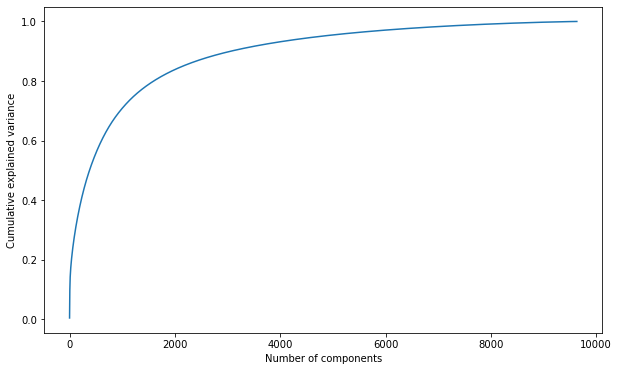

In [26]:
# Example with TruncatedSVD
svd = TruncatedSVD(n_components = 9633)  # Start with a larger number of components
reduced_data = svd.fit_transform(dtm)

# Plot the cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

- We can see from the above chart that 4000 features make up for 90% of the importance; 2000 features make up for 80% of the importance

In [28]:
svd_1 = TruncatedSVD(n_components=2000)
reduced_data_1 = svd_1.fit_transform(dtm)
print(f"Total variance explained: {np.sum(svd_1.explained_variance_ratio_):.2f}")

Total variance explained: 0.84


### 3.3 Clustering
- Use K-means for clustering, and since we have 10 labels in the dataset, we're trying to do 10 clusters.

In [32]:
# Use K-means for clustering
X1 = reduced_data_1
kmeans = KMeans(n_clusters=10, random_state=0).fit(X1)
kmeans.labels_

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x2adac6a19dc0>
Traceback (most recent call last):
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._fi

array([7, 7, 7, ..., 4, 4, 4], dtype=int32)

In [34]:
# Evaluate Clustering
silhouette_avg = silhouette_score(reduced_data_1, kmeans.labels_)
print("Silhouette Score: ", silhouette_avg)

Silhouette Score:  0.04776969568770763


- Let's check the k-means clustering with the original labels

In [38]:
result = kmeans.labels_

# Create a dictionary for the count of data points for each label
dictionary1 = {0: 2268, 1:808, 2:1958, 3:9753, 4:5405, 5:6909, 6:1597, 7:4101, 8:4196, 9:5151}

start = 0
prediction_groups = {}
for idx, count in dictionary1.items():
    prediction_groups[f'prediction_group_{idx}'] = result[start:start+count]
    start += count

# For each label, print it's cluster labels
for label, value in prediction_groups.items():
    print(label)
    unique_values, counts = np.unique(value, return_counts=True)
    print(dict(zip(unique_values, counts)))  

prediction_group_0
{5: 29, 7: 2239}
prediction_group_1
{5: 740, 8: 68}
prediction_group_2
{3: 112, 5: 23, 8: 1823}
prediction_group_3
{3: 7740, 5: 1854, 9: 159}
prediction_group_4
{0: 395, 5: 3, 9: 5007}
prediction_group_5
{0: 6387, 1: 1, 2: 495, 4: 1, 5: 25}
prediction_group_6
{1: 555, 2: 1036, 5: 6}
prediction_group_7
{1: 3343, 5: 24, 6: 732, 8: 1, 9: 1}
prediction_group_8
{4: 796, 5: 5, 6: 3395}
prediction_group_9
{4: 4294, 5: 14}


#### Conclusion
- By looking at the silhouette score 0.047, which is pretty low, we think the clustering is not perfectly fit with our data; For non-standardized text, this outcome is not surprising
- However, if we look at the labels correlation to the clusters, each label do correspond to mainly one cluster. We think the cluster performance is not that bad

#### More Thoughts
- We learned lots of machine learning techniques from this assignment, however, our solution to deal with the data is not the best
- In reality, if we want to deal with physician notes, it's important that we format the notes, standardize the medical categories/process for the notes, and use medical dictionary to extract abbreviations
- Moreover, it's worth considering using Large Language Models to summarize the notes first and then perform the ML techniques